In [67]:
import pandas as pd
import numpy as np
from numpy import argmax, array_equal

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("fivethirtyeight")
color_pal = sns.color_palette()

import shap
import xgboost
import optuna
from imgaug import augmenters
from random import randint
import plotly.graph_objects as go
import plotly.figure_factory as ff
from itertools import product
import statsmodels.api as sm
from tqdm import tqdm
import plotly.graph_objects as go
import plotly.figure_factory as ff
from imblearn.over_sampling import SMOTENC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier as cb

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor , AdaBoostClassifier, RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier as cb
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTENC

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier,XGBRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeClassifier, RidgeClassifierCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import TensorBoard
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Conv2D, MaxPool2D,MaxPooling2D, UpSampling2D,Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.utils import plot_model
from keras.models import load_model, Model
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam, SGD
from tensorflow.keras.optimizers import Adam, SGD
from subprocess import check_output
import warnings
warnings.filterwarnings('ignore')

epochs = 20
num_classes = 10
seed = 42

In [2]:
us = pd.read_csv('/kaggle/input/bitcoin-prices-usd/bitcoin_prices(USD).csv')
us

,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
0,2013-10-01,123.654990,124.304660,124.751660,122.563490
1,2013-10-02,125.455000,123.654990,125.758500,123.633830
2,2013-10-03,108.584830,125.455000,125.665660,83.328330
3,2013-10-04,118.674660,108.584830,118.675000,107.058160
4,2013-10-05,121.338660,118.674660,121.936330,118.005660
...,...,...,...,...,...
3635,2023-09-14,26539.673828,26228.277344,26774.623047,26171.451172
3636,2023-09-15,26608.693359,26533.818359,26840.498047,26240.701172
3637,2023-09-16,26568.281250,26606.199219,26754.769531,26473.890625
3638,2023-09-17,26534.187500,26567.927734,26617.998047,26445.074219


In [4]:
for col in us:
    print("Column : ", col)
    print(f"Value counts of {col}: ",us[col].value_counts().sum())
    print(f"Number of Unique Values in {col}: ",us[col].nunique())
    print()

Column :  Date
Value counts of Date:  3640
Number of Unique Values in Date:  3640

Column :  Closing Price (USD)
Value counts of Closing Price (USD):  3640
Number of Unique Values in Closing Price (USD):  3637

Column :  24h Open (USD)
Value counts of 24h Open (USD):  3640
Number of Unique Values in 24h Open (USD):  3636

Column :  24h High (USD)
Value counts of 24h High (USD):  3640
Number of Unique Values in 24h High (USD):  3637

Column :  24h Low (USD)
Value counts of 24h Low (USD):  3640
Number of Unique Values in 24h Low (USD):  3639



In [5]:
us.describe(percentiles=[0.1, 0.25, 0.75, 0.9, 0.95]).T

,count,mean,std,min,10%,25%,50%,75%,90%,95%,max
Closing Price (USD),3640.0,12642.867212,15693.562969,108.58483,325.877698,614.403747,6765.250000,19427.987793,38737.869922,47783.857422,67566.828125
24h Open (USD),3640.0,12636.759124,15696.166093,108.58483,325.904687,613.612991,6750.745118,19421.058594,38748.789844,47814.004883,67549.734375
24h High (USD),3640.0,12938.307813,16080.447240,118.67500,333.836310,622.502808,6889.210693,19852.138183,39798.680078,49206.910156,68789.625000
24h Low (USD),3640.0,12306.045038,15258.276932,83.32833,316.755692,605.876983,6614.339844,19077.496582,37585.637891,46751.255469,66382.062500


In [6]:
us = us.set_index("Date")
us.index = pd.to_datetime(us.index)
us.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3640 entries, 2013-10-01 to 2023-09-18
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Closing Price (USD)  3640 non-null   float64
 1   24h Open (USD)       3640 non-null   float64
 2   24h High (USD)       3640 non-null   float64
 3   24h Low (USD)        3640 non-null   float64
dtypes: float64(4)
memory usage: 142.2 KB


<Axes: title={'center': 'Bitcoin Price (USD)'}, xlabel='Date'>

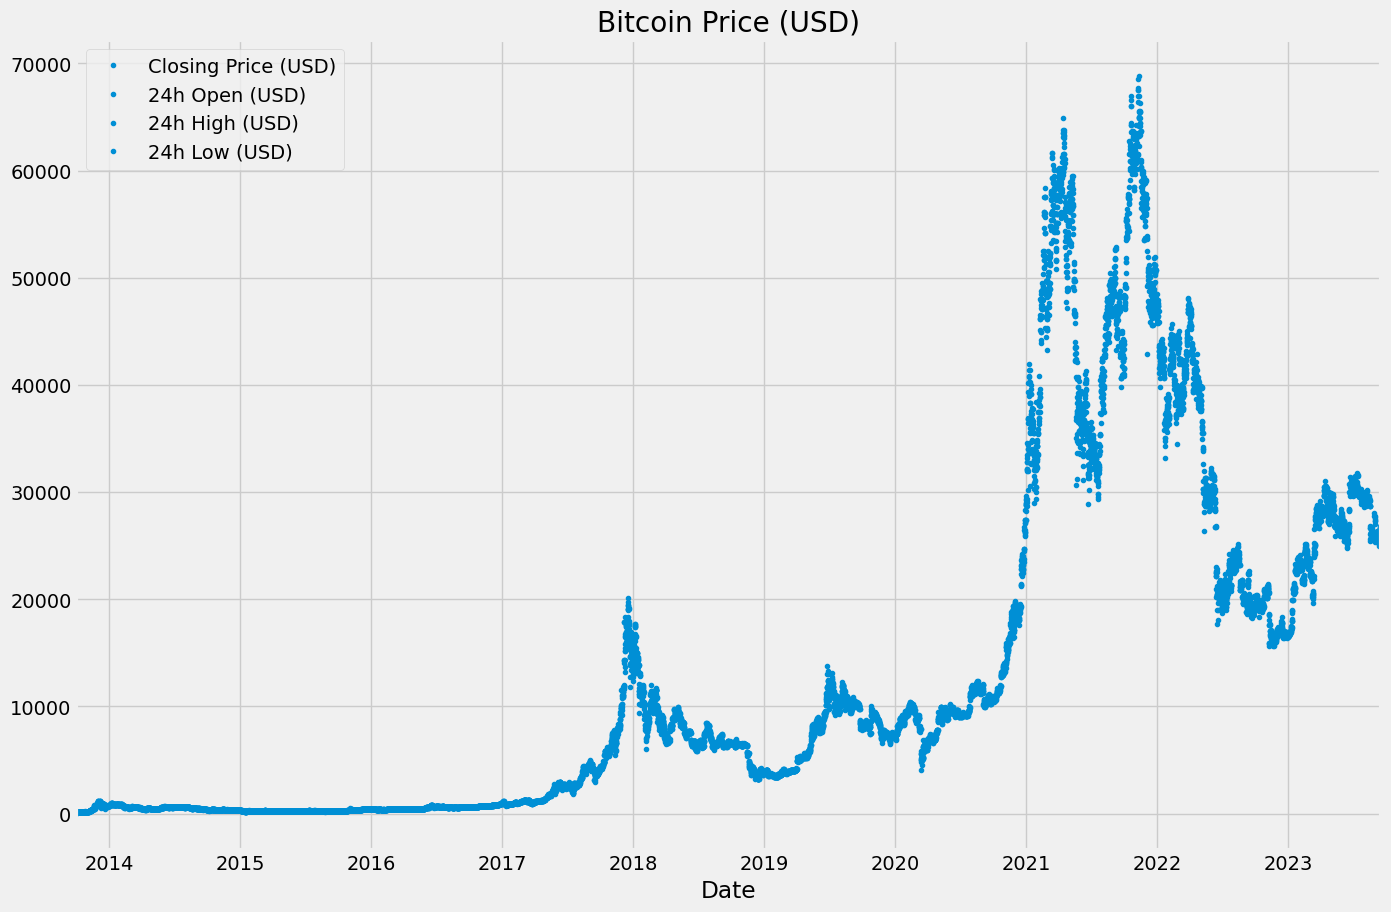

In [13]:
us.plot(figsize=(15,10),style='.',color=color_pal[0],title='Bitcoin Price (USD)')

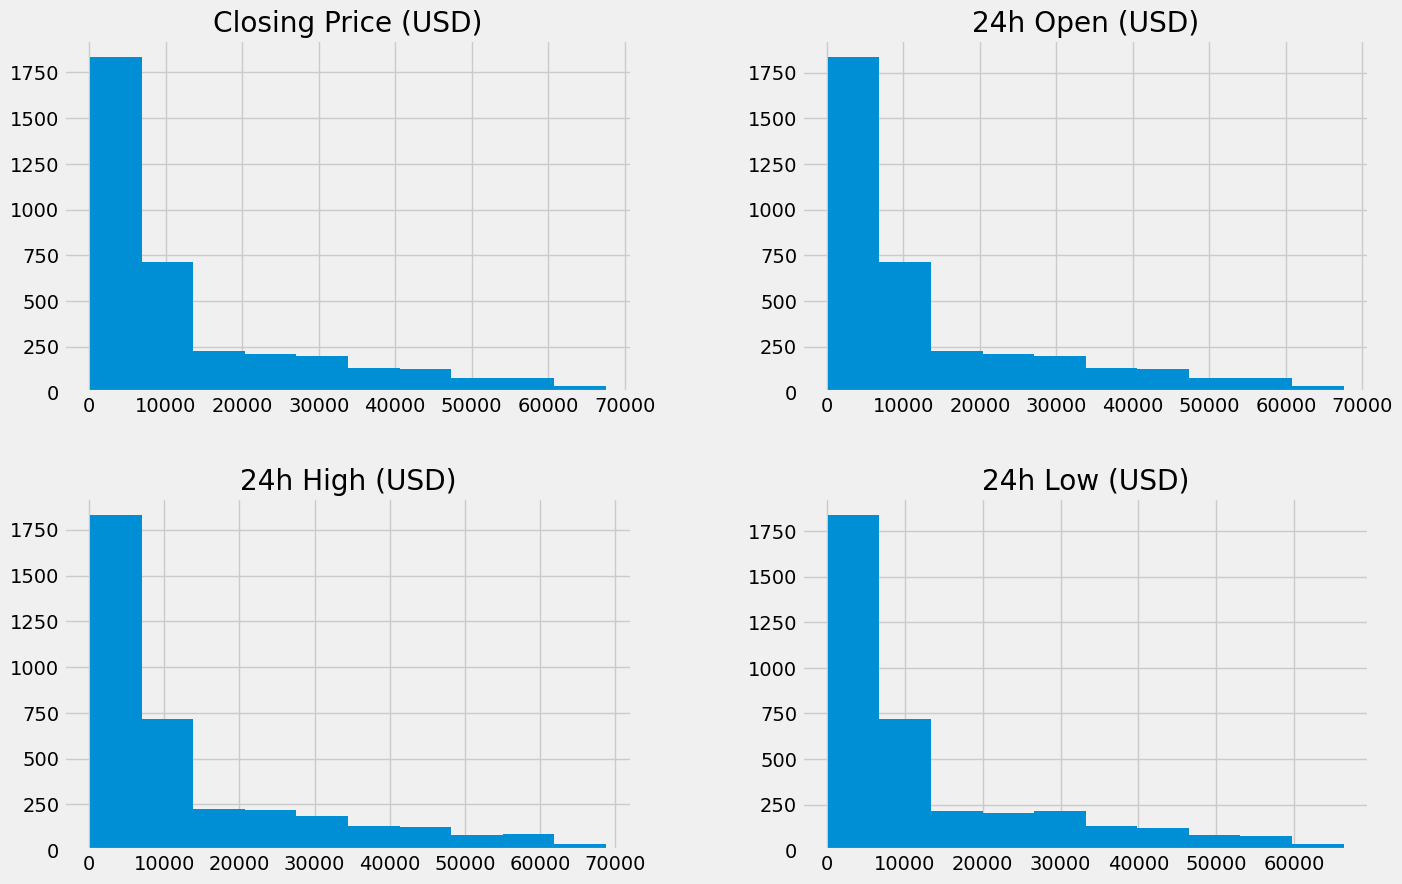

In [14]:
us.hist(figsize=(15,10))
plt.show()

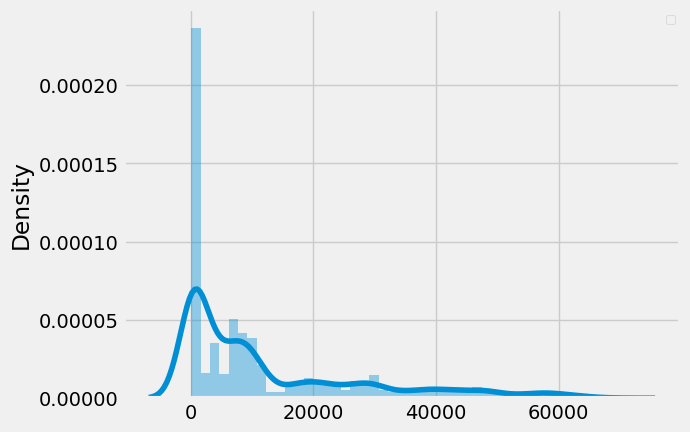

In [15]:
figure = sns.distplot(us)
figure = figure.legend(loc='best', fontsize=8)

[Text(0.5, 1.0, 'A Heat map to show relationship between variables')]

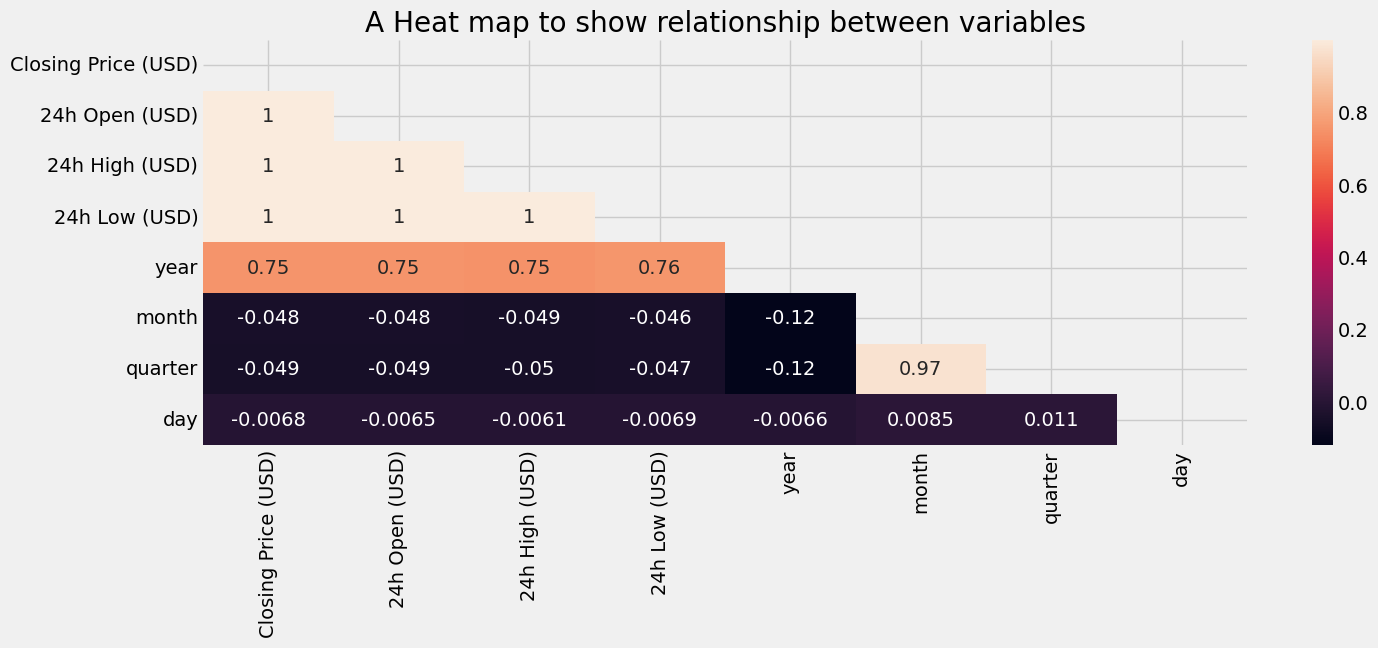

In [17]:
plt.figure(figsize=(15,5))
sns.heatmap(us.corr(),annot=True,mask=np.triu(np.ones_like(us.corr()))).set(title='A Heat map to show relationship between variables')

In [16]:
us["year"] = us.index.year
us["month"] = us.index.month
us["quarter"] = us.index.quarter
us["day"] = us.index.day
us
us

,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD),year,month,quarter,day
Date,,,,,,,,
2013-10-01,123.654990,124.304660,124.751660,122.563490,2013,10,4,1
2013-10-02,125.455000,123.654990,125.758500,123.633830,2013,10,4,2
2013-10-03,108.584830,125.455000,125.665660,83.328330,2013,10,4,3
2013-10-04,118.674660,108.584830,118.675000,107.058160,2013,10,4,4
2013-10-05,121.338660,118.674660,121.936330,118.005660,2013,10,4,5
...,...,...,...,...,...,...,...,...
2023-09-14,26539.673828,26228.277344,26774.623047,26171.451172,2023,9,3,14
2023-09-15,26608.693359,26533.818359,26840.498047,26240.701172,2023,9,3,15
2023-09-16,26568.281250,26606.199219,26754.769531,26473.890625,2023,9,3,16


In [75]:
x = us.drop("Closing Price (USD)", axis=1)
y = us['Closing Price (USD)']

In [86]:
x = np.array(x, dtype = 'float32')
y = np.array(y, dtype='float32')

In [77]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=seed)

print("Training Data Shape : ", xtrain.shape, ytrain.shape)
print("Test Data Shape : ", xtest.shape, ytest.shape)

Training Data Shape :  (2912, 7) (2912,)
Test Data Shape :  (728, 7) (728,)


In [21]:
model_params = {
    'linear_regression':{
        'model':LinearRegression(),
        'params':{

        }
    },
    'Decision_Tree':{
        'model':DecisionTreeRegressor(),
        'params':{
            'max_depth':[10,20,50,100],
            'random_state':[0,42]
        }
    },
    'Random_Forest':{
        'model':RandomForestRegressor(),
        'params':{
            'n_estimators':[10,20,50,100,200]
        }
    },
    'Ridge_regression':{
        'model':Ridge(tol=0.1),
        'params':{
             'alpha':[1,10,20,50,100],
            'max_iter':[50,100,200]
        }
    },
    'Lasso_regression':{
        'model':Lasso(tol=0.1),
        'params':{
            'alpha':[1,10,20,50,100],
            'max_iter':[50,100,200]
        }
    },
    'XGBRegressor':{
        'model':XGBRegressor(),
        'params':{
            'n_estimator':[1000],
            'early_stopping_round':[50]
        }
    }

}

In [22]:
score=[]
best_score = 0
second_best_score = 0
best_model = None        # This is the best model in the end of the grid search cv
second_best_model = None #This is the second best model in the end of the grid search cv
for model_name,m in model_params.items():
    clf = GridSearchCV(m['model'],m['params'],cv=5)
    clf.fit(xtrain,ytrain)

    if best_score<clf.best_score_:
        second_best_score =  best_score
        second_best_model =  best_model
        best_score = clf.best_score_
        best_model = clf.best_estimator_
    elif clf.best_score_>second_best_score:
        second_best_score = clf.best_score_
        second_best_model = clf.best_estimator_

    score.append({
        'model':model_name,
        'score':clf.best_score_,
        'param':clf.best_params_
    })


pd.DataFrame(score)

[09:57:37] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round", "n_estimator" } are not used.

[09:57:37] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round", "n_estimator" } are not used.

[09:57:37] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round", "n_estimator" } are not used.

[09:57:37] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round", "n_estimator" } are not used.

[09:57:38] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round", "n_estimator" } are not used.

[09:57:38] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stopping_round", "n_estimator" } are not used.



,model,score,param
0,linear_regression,0.999587,{}
1,Decision_Tree,0.998602,"{'max_depth': 20, 'random_state': 0}"
2,Random_Forest,0.999187,{'n_estimators': 100}
3,Ridge_regression,0.999587,"{'alpha': 100, 'max_iter': 50}"
4,Lasso_regression,0.997742,"{'alpha': 1, 'max_iter': 50}"
5,XGBRegressor,0.999082,"{'early_stopping_round': 50, 'n_estimator': 1000}"


In [31]:
print('Best Model :', best_model.score(xtest,ytest)),
print('-------------------------------------------')
print('Second Best Model :', second_best_model.score(xtest,ytest))

Best Model : 0.9996605109899442
-------------------------------------------
Second Best Model : 0.999660435674256


In [35]:
print('Best Model :', best_model),
print('---------------------------------------------------')
print('Second Best Model :', second_best_model)

Best Model : Ridge(alpha=100, max_iter=50, tol=0.1)
---------------------------------------------------
Second Best Model : LinearRegression()


In [36]:
models = {
     'Ridge':best_model,
    'LinearRegression':second_best_model
}

result=[]
for model_name,model in models.items():
    ypred = model.predict(xtest)
    mse = mean_squared_error(ytest,ypred)
    rmse = mean_squared_error(ytest,ypred,squared = False)

    result.append({
        'Model':model_name,
        'MSE':mse,
        'RMSE':rmse
    })

pd.DataFrame(result)

,Model,MSE,RMSE
0,Ridge,76441.138667,276.479906
1,LinearRegression,76458.097145,276.510573


In [48]:
train0 = np.array(us[:int(us.shape[0]*0.8)])
test0 = np.array(us[int(us.shape[0]*0.8):])
scaler = MinMaxScaler(feature_range=(0,1))
train = scaler.fit_transform(train0)
test = scaler.transform(test0)
def create_dataset(us):
    x = []
    y = []
    for i in range(50, us.shape[0]):
        x.append(us[i-50:i, 0])
        y.append(us[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x,y

xtrain, ytrain = create_dataset(train)
xtest, ytest = create_dataset(test)
xtrain = np.reshape(xtrain, (xtrain.shape[0], xtrain.shape[1], 1))
xtest = np.reshape(xtest, (xtest.shape[0], xtest.shape[1], 1))

In [58]:
model = Sequential()

model.add(LSTM(units=96, return_sequences=True, input_shape=(xtrain.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50, 96)            37632     
                                                                 
 dropout_4 (Dropout)         (None, 50, 96)            0         
                                                                 
 lstm_5 (LSTM)               (None, 50, 96)            74112     
                                                                 
 dropout_5 (Dropout)         (None, 50, 96)            0         
                                                                 
 lstm_6 (LSTM)               (None, 50, 96)            74112     
                                                                 
 dropout_6 (Dropout)         (None, 50, 96)            0         
                                                                 
 lstm_7 (LSTM)               (None, 96)               

In [62]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

us['Closing Price (USD)']

Date
2013-10-01      123.654990
2013-10-02      125.455000
2013-10-03      108.584830
2013-10-04      118.674660
2013-10-05      121.338660
                  ...     
2023-09-14    26539.673828
2023-09-15    26608.693359
2023-09-16    26568.281250
2023-09-17    26534.187500
2023-09-18    26754.281250
Name: Closing Price (USD), Length: 3640, dtype: float64